# All Regression Notebook
## Load dữ liệu
Khai báo và load thư viện, sau đó load tập dữ liệu. Do tập dữ liệu không chứa tên cột nên chúng ta cần thêm nó vào bằng cách sử dụng list Python thủ công.

Chúng ta có `all_train_data` và `all_test_data` đã được nối vào `DataFrame` tương ứng.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
#=================Chạy 1 lần duy nhất
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/Bai tap lap/Mon_hoc_2/assignment1/data/Dataset.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab_Notebooks/Bai tap lap/Mon_hoc_2/assignment1/data")
zip_ref.close()
"""

In [3]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]
all_train_data = [pandas.read_csv("/content/drive/MyDrive/Colab_Notebooks/Bai tap lap/Mon_hoc_2/assignment1/data/Dataset/Training/Features_Variant_{:d}.csv".format(d), header=None) for d in range(1, 6)]
for data in all_train_data:
    print("Train sets size: {:d}".format(data.size))

#================================= Viết code nối dữ liệu huấn luyện
train_data = pandas.concat(all_train_data)
train_data.columns = columns_name

all_test_data = [pandas.read_csv("/content/drive/MyDrive/Colab_Notebooks/Bai tap lap/Mon_hoc_2/assignment1/data/Dataset/Testing/TestSet/Test_Case_{:d}.csv".format(d), header=None) for d in range(1, 10)]
for data in all_test_data:
  print("Test set size: {:d}".format(data.size))
#=============================== Viết code nối dữ liệu kiểm tra
test_data = pandas.concat(all_test_data)
test_data.columns = columns_name

train_data["bias"] = 1
test_data["bias"] = 1

train_data.head()


Train sets size: 2211246
Train sets size: 4390848
Train sets size: 6539292
Train sets size: 8662896
Train sets size: 10747620
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400
Test set size: 5400


,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,...,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,1,0,0,1
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,1,0,0,0,0,0,0,1
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,1,0,0,0,0,1


In [4]:
#==================== Ham Value_counts xắp xếp r
#==================== Hàm tìm category có nhiều giá trị nhất: largest_category

mm = train_data['Category'].value_counts().copy()
mm2 = list(mm.index)
largest_category = mm2[0]
print(largest_category)
"""
x = pandas.DataFrame(mm)
x.columns = ['category']
x.reset_index(inplace=True)
k = x.sort_values(by = ['category'], ascending=False)
largest_category = k['index'].iloc[0]
print(type(largest_category))
"""

9


"\nx = pandas.DataFrame(mm)\nx.columns = ['category']\nx.reset_index(inplace=True)\nk = x.sort_values(by = ['category'], ascending=False)\nlargest_category = k['index'].iloc[0]\nprint(type(largest_category))\n"

## Lựa chọn hạng mục phụ
Cột Category chứa các index bất kỳ của hạng mục dữ liệu liên quan tới bản chất của chính bài đăng. Để đơn giản, chúng ta sẽ sử dụng hạng mục có lượng dữ liệu lớn nhất để thực hiện Hồi quy Tuyến tính.

Tìm và lựa chọn hạng mục có nhiều bản ghi nhất sử dụng pandas. Lưu nó trong biến `largest_category`

In [5]:
# Phân hạng các mô hình
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

## Tương quan cơ bản
Chúng ta sẽ vẽ ma trận tương quan giữa các biến CC. Tương quan rất hữu ích để xem liệu các đặc trưng có kết nối quá chặt chẽ không -  chúng ta không muốn chúng cùng nhau vì chúng sẽ tạo ra nhiễu giả gây overfit mô hình.

          CC1       CC2       CC3       CC4       CC5
CC1  1.000000  0.581207  0.665784  0.998054 -0.054450
CC2  0.581207  1.000000  0.074723  0.605900  0.686801
CC3  0.665784  0.074723  1.000000  0.656649 -0.673494
CC4  0.998054  0.605900  0.656649  1.000000 -0.029488
CC5 -0.054450  0.686801 -0.673494 -0.029488  1.000000


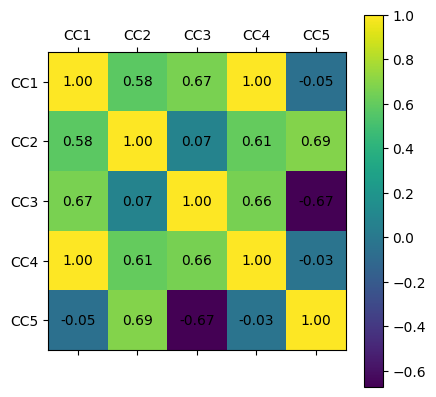

In [6]:
# Viết code ở đây:
cc_list = ["CC{:d}".format(i) for i in range(1, 6)]

corr = pandas.DataFrame(train_features[cc_list]).corr()

print(pandas.DataFrame(train_features[cc_list]).corr())

plt.matshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(i, j, '{:.2f}'.format(corr.iloc[i,j]), ha='center', va='center')

plt.show()

## Xây dựng mô hình Hồi quy

__Nhiệm vụ của chúng ta là dự đoán số lượng bình luận bài đăng sẽ nhận được (cột "Span count")__ <br>
"Span time" thì cần thiết trong khi tất cả các cột khác tùy chọn. <br>
Thử mô hình Hồi quy đa biến đơn giản chỉ có các đặc trưng cơ bản: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]. <br>

In ra hệ số MSE từ sklearn hoặc RSS từ khóa học cho cả tập huấn luyện và tập kiểm tra.

In [7]:
# Viết code ở đây:
list1 = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]
name1 = "Span count"
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#train_new, val_new = train_test_split(train_data,test_size= 0.1, train_size=0.9, random_state=1)


train_data_1 = train_data[list1].values
train_label_1 = train_data[name1].values
#val_data_1 = val_new[list1].values
#val_label_1 = val_new[name1].values
test_data_1 = test_data[list1].values
test_label_1 = test_data[name1].values

model_1 = LinearRegression().fit(train_data_1, train_label_1)

In [8]:
from sklearn.metrics import mean_squared_error

predict_train_1 = model_1.predict(train_data_1)
predict_test_1 = model_1.predict(test_data_1)

error_train_1 = predict_train_1 - train_label_1
error_test_1 = predict_test_1 - test_label_1

#==================check bằng hàm  mean_squared_error
MSS_train_check = mean_squared_error(predict_train_1, train_label_1)
MSS_test_check = mean_squared_error(predict_test_1, test_label_1)

print(MSS_train_check, MSS_test_check)

MSE_train = (error_train_1@error_train_1)/len(error_train_1)
MSE_test = (error_test_1@error_test_1)/len(error_test_1)

print("MSE of train, test : {:.2f} {:.2f}".format(MSE_train, MSE_test))

1689.5665198601353 5340.589651600935
MSE of train, test : 1689.57 5340.59


### Hãy thử cải thiện với nhiều đặc trưng hơn
Không phải mô hình tốt nhất chúng ta có thể sử dụng. Chúng ta có thể thử thêm nhiều đặc trưng liên quan. <br>Nối tất cả các thuộc tính CC vào các đặc trưng và thử lại với cùng số liệu.

In [9]:
# Viết code ở đây:
#===========================================Tạo list thêm các đặc trưng cc
list2 = list1.copy()
list2 = list2 + cc_list
name2 = "Span count"
print(list2)

train_data_2 = train_data[list2].values
train_label_2 = train_data[name2].values
#val_data_1 = val_new[list1].values
#val_label_1 = val_new[name1].values
test_data_2 = test_data[list2].values
test_label_2 = test_data[name2].values

model_2 = LinearRegression().fit(train_data_2, train_label_2)

predict_train_2 = model_2.predict(train_data_2)
predict_test_2 = model_2.predict(test_data_2)

error_train_2 = predict_train_2 - train_label_2
error_test_2 = predict_test_2 - test_label_2

MSE_train_2 = (error_train_2@error_train_2)/len(error_train_2)
MSE_test_2 = (error_test_2@error_test_2)/len(error_test_2)

print("MSE of train, test : {:.2f} {:.2f}".format(MSE_train_2, MSE_test_2))

['Popularity', 'Base time', 'Post length', 'Post count', 'Span time', 'bias', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5']
MSE of train, test : 1535.02 3878.53


Bài học rút ra: Tối ưu hóa sớm hiếm khi hữu ích.

## Giải quyết overfit
### Áp dụng cách giải cho overfit

Sự khác biệt về hệ số huấn luyện và kiểm tra chỉ ra mô hình có thể overfitting. Hãy thử sửa chữa. Mở rộng hồi quy [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) (cv = 10) với alpha dọc theo logspace giữa 0 và 10, ghi nhận giá trị có chất lượng tốt nhất thành biến `best_alpha`, và *có thể tùy chọn vẽ một đồ thị cho độ lớn của các hệ số*.

In [10]:
from numpy.core.function_base import logspace
from sklearn.linear_model import RidgeCV

import warnings


# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

# Viết code ở đây:
alpha = np.logspace(0,10,100)
model = []
weights = []
RSS_test = []
RSS_train =[]

#=====================chạy model với từng alpha với cv = 10 lưu các trọng số (weights) ứng với cv=10, lưu RSS của test và train
for i in alpha:
  model_check =RidgeCV(alphas=[i], cv=10)
  model_check.fit(train_data_2, train_label_2)
  weights.append(model_check.coef_)
  predicted_value = model_check.predict(test_data_2)
  error_cal = predicted_value - test_label_2
  RSS_test.append(error_cal@error_cal)

  predicted_train = model_check.predict(train_data_2)
  error_train = predicted_train - train_label_2
  RSS_train.append(error_train@error_train)

In [11]:
x = np.array(weights)
print(x)


[[ 9.91979791e-07 -4.30641391e-01  3.06804004e-04 ...  2.71663005e-02
  -4.24224376e-02  5.50348771e-02]
 [ 9.91979792e-07 -4.30641388e-01  3.06804001e-04 ...  2.71663082e-02
  -4.24224344e-02  5.50348848e-02]
 [ 9.91979792e-07 -4.30641385e-01  3.06803997e-04 ...  2.71663205e-02
  -4.24224304e-02  5.50348972e-02]
 ...
 [ 1.25130425e-06 -4.46267739e-03  2.30757508e-04 ... -4.62536790e-03
   5.51181107e-03  2.38849486e-02]
 [ 1.27973754e-06 -3.61485804e-03  1.98647446e-04 ... -4.05130208e-03
   5.05980421e-03  2.04008945e-02]
 [ 1.30969047e-06 -2.92000696e-03  1.66905749e-04 ... -3.45828831e-03
   4.59369171e-03  1.72282915e-02]]


Text(0.5, 1.0, 'Weights change depending on alpha')

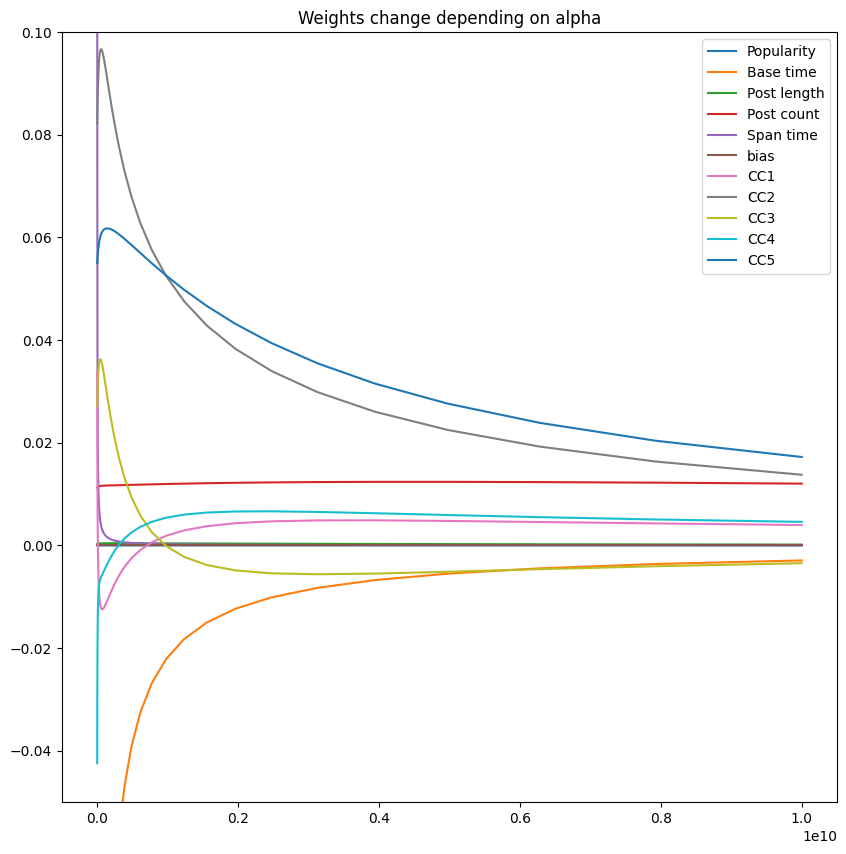

In [12]:
#=================== vẽ đồ thị weights khi alpha thay đổi
"""
row = 4
colum = 3
figure, axis = plt.subplots(4, 3)
kk = 0
for i in range(row):
    for j in range(colum):
        if kk == 11: break
        axis[i,j].plot(alpha, x[:, kk])
        axis[i, j].set_title("Weight_{}".format(kk))
        kk+=1

axis[row-1,colum-1].plot(alpha, RSS_test)
axis[row-1,colum-1].set_title("RSS_set")
# Combine all the operations and display
plt.show()
"""
plt.figure(figsize=(10,10))
for i in range(len((list2))):
    plt.plot(alpha, x[:, i], label=list2[i])
plt.ylim(-0.05, 0.1)
plt.legend(loc='upper right')
plt.title("Weights change depending on alpha")

#============= chia thang 0.01

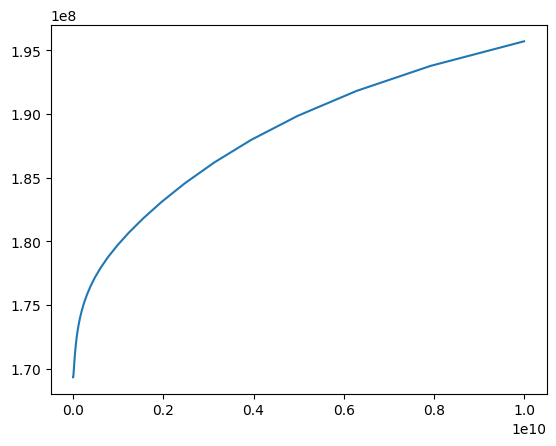

In [13]:
#===========================vẽ đồ thị RSS_train
plt.plot(alpha, RSS_train)


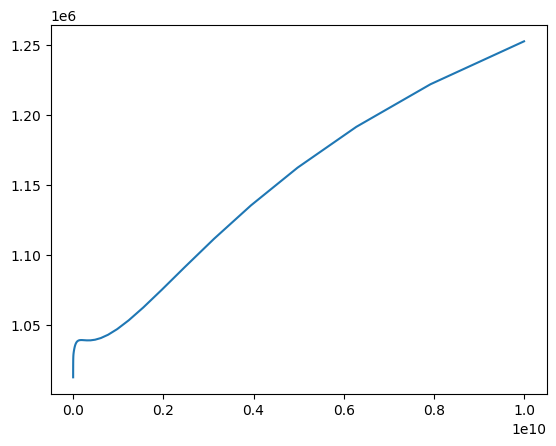

In [14]:
plt.plot(alpha, RSS_test)

In [15]:
#============================ RSS min ứng với alpha = 1.
ll = np.array(RSS_test)
print(alpha[ll.argmin()])

1.0


### Thử Hồi quy RidgeCV trên mọi cột
Nó đã hoạt động, nhưng chúng ta cần tự hỏi liệu có tiếp tục sử dụng tập đặc trưng không hoàn thiện thay vì một tập hợp tối ưu nữa không. Mở rộng các đặc trưng cho tất cả các cột trừ nhãn được chỉ định. Hãy chạy và xem điều gì sẽ xảy ra.

In [16]:
#==========================model ứng với feature toàn cột ngoại trừ label( vì label là đầu ra)

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

model_alfeature = []
weights_alfeature = []
RSS_test_alfeature = []
RSS_train_alfeature =[]

#========================tương tự như trên với alpha = logspace(0,10,100)
for i in alpha:
  model_check =RidgeCV(alphas=[i], cv=10)
  model_check.fit(train_features, train_labels)
  weights_alfeature.append(model_check.coef_)
  predicted_value = model_check.predict(test_features)
  error_cal = predicted_value - test_labels
  RSS_test_alfeature.append(error_cal@error_cal)

  predicted_train = model_check.predict(train_features)
  error_train = predicted_train - train_labels
  RSS_train_alfeature.append(error_train@error_train)

xx = np.array(weights_alfeature)
print(xx)

#====================vẽ đồ thị
"""
row = 4
colum = 3
figure, axis = plt.subplots(4, 3)
kk = 0
for i in range(row):
    for j in range(colum):
        if kk == 11: break
        axis[i,j].plot(alpha, xx[:, kk])
        axis[i, j].set_title("Weight_{}".format(kk))
        kk+=1

axis[row-1,colum-1].plot(alpha, RSS_test_alfeature)
axis[row-1,colum-1].set_title("RSS_set_alfeature")
# Combine all the operations and display
plt.show()
"""



[[ 5.58482826e-07 -1.24296113e-05 -1.01741283e-05 ... -1.21168065e+00
  -6.68944871e-01  0.00000000e+00]
 [ 5.58482738e-07 -1.24296272e-05 -1.01741321e-05 ... -1.21162711e+00
  -6.68897245e-01  0.00000000e+00]
 [ 5.58482627e-07 -1.24296474e-05 -1.01741370e-05 ... -1.21155956e+00
  -6.68837156e-01  0.00000000e+00]
 ...
 [ 1.02450644e-06 -1.86316725e-05 -4.83499402e-06 ... -3.49850411e-06
  -4.39490405e-07  0.00000000e+00]
 [ 1.04809510e-06 -1.82648221e-05 -4.40233658e-06 ... -2.85664909e-06
  -3.95469349e-07  0.00000000e+00]
 [ 1.07113671e-06 -1.78428982e-05 -3.96064694e-06 ... -2.32284089e-06
  -3.43887317e-07  0.00000000e+00]]


'\nrow = 4\ncolum = 3\nfigure, axis = plt.subplots(4, 3)\nkk = 0\nfor i in range(row):\n    for j in range(colum):\n        if kk == 11: break\n        axis[i,j].plot(alpha, xx[:, kk])\n        axis[i, j].set_title("Weight_{}".format(kk))\n        kk+=1\n\naxis[row-1,colum-1].plot(alpha, RSS_test_alfeature)\naxis[row-1,colum-1].set_title("RSS_set_alfeature")\n# Combine all the operations and display\nplt.show()\n'

Text(0.5, 1.0, 'Weights change depending on alpha')

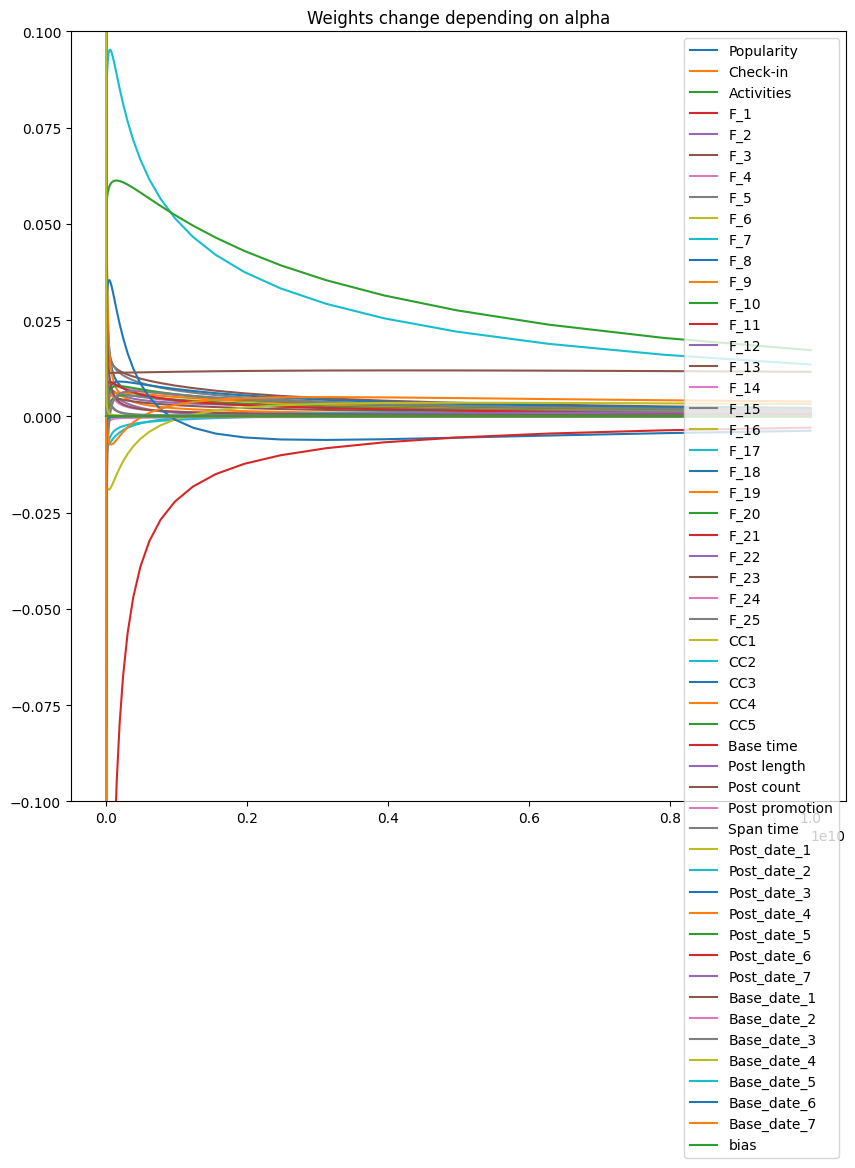

In [17]:
plt.figure(figsize=(10,10))
for i in range(len((features))):
    plt.plot(alpha, xx[:, i], label=features[i])
plt.ylim(-0.1, 0.1)
plt.legend(loc='upper right')
plt.title("Weights change depending on alpha")

#=========================ZOOM

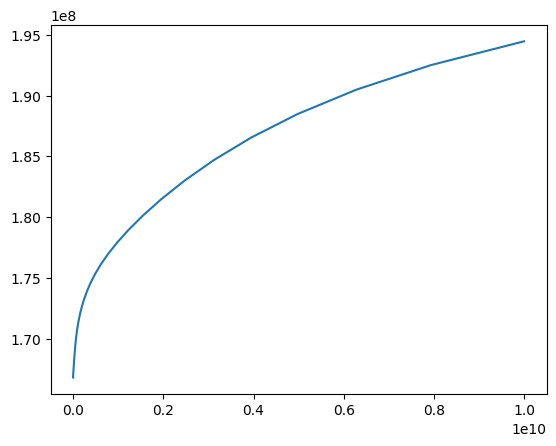

In [ ]:
plt.plot(alpha, RSS_train_alfeature)

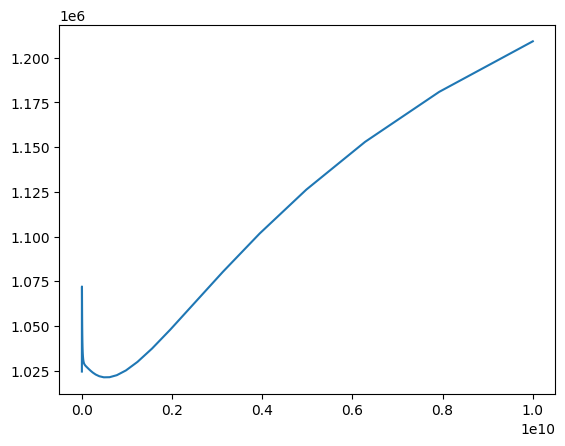

In [ ]:
plt.plot(alpha, RSS_test_alfeature)

In [ ]:
#=================================RSS trên tập test min ứng với alpha = 486260158.00653535
ll2 = np.array(RSS_test_alfeature)
print(alpha[ll2.argmin()])
print(alpha)

486260158.00653535
[1.00000000e+00 1.26185688e+00 1.59228279e+00 2.00923300e+00
 2.53536449e+00 3.19926714e+00 4.03701726e+00 5.09413801e+00
 6.42807312e+00 8.11130831e+00 1.02353102e+01 1.29154967e+01
 1.62975083e+01 2.05651231e+01 2.59502421e+01 3.27454916e+01
 4.13201240e+01 5.21400829e+01 6.57933225e+01 8.30217568e+01
 1.04761575e+02 1.32194115e+02 1.66810054e+02 2.10490414e+02
 2.65608778e+02 3.35160265e+02 4.22924287e+02 5.33669923e+02
 6.73415066e+02 8.49753436e+02 1.07226722e+03 1.35304777e+03
 1.70735265e+03 2.15443469e+03 2.71858824e+03 3.43046929e+03
 4.32876128e+03 5.46227722e+03 6.89261210e+03 8.69749003e+03
 1.09749877e+04 1.38488637e+04 1.74752840e+04 2.20513074e+04
 2.78255940e+04 3.51119173e+04 4.43062146e+04 5.59081018e+04
 7.05480231e+04 8.90215085e+04 1.12332403e+05 1.41747416e+05
 1.78864953e+05 2.25701972e+05 2.84803587e+05 3.59381366e+05
 4.53487851e+05 5.72236766e+05 7.22080902e+05 9.11162756e+05
 1.14975700e+06 1.45082878e+06 1.83073828e+06 2.31012970e+06
 2.91

## Lựa chọn đặc trưng
### Áp dụng LASSO
Chúng ta có thể cắt tỉa các đặc trưng sử dụng những gì đã học. Lần này sẽ ghi lại các đặc trưng đã chọn của [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) (cv = 10) sử dụng biến `lasso_selected_features`, và <i>có thể tùy chọn vẽ một đồ thị giữa số lượng đặc trưng đã loại và các giá trị alpha</i>.

In [19]:
#====================Trong kernal này sử dụng LASSOCV với alphas = np.logspace(0,10,20)



from sklearn.linear_model import LassoCV
# Viết code ở đây:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[features]
train_labels = train_data[label]
test_features = test_data[features]
test_labels = test_data[label]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


multi_model = LassoCV(alphas = alpha,cv=10)
multi_model.fit(train_features,train_labels)
test_predictions = multi_model.predict(test_features)

test_mse_score = mean_squared_error(test_predictions, test_labels)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1522.9144; MSE on test: 4072.2761


In [20]:
#================================Trong kernel này: ghi ra các features có trọng số khác 0 ứng với alphas = np.logspace(0,10,20) và model đã chọn trường hợp tối ưu,
#================================ với khoảng logspace(0,10,20) chỉ luôn có 8 features có trọng số khác 0

# Viết code ở đây:
ee = multi_model.coef_
mask = ee != 0
lasso_selected_features = []
print("Cac feature co weight != 0:")
for index, i in enumerate(ee):
    if i: lasso_selected_features.append(features[index])
print(lasso_selected_features)

Cac feature co weight != 0:
['F_5', 'F_8', 'F_9', 'F_14', 'CC2', 'CC5', 'Base time', 'Post count']


In [21]:

#================================Test ngoài lề
#================================Trong kernel này: chạy với alphas = alpha_test = np.linspace(0.01,0.02,50) bởi vì em đã có chạy trước đó LASSOCV để alphas tự động mặc định
mul_lasso_No_coef = []
mul_lasso_value_coefs = []
train_RSS_LASSO = []
test_RSS_LASSO = []
alpha_test = np.linspace(0.01,0.02,50)
for i in alpha_test:
    multi_model_check = LassoCV(alphas = [i],cv=10)
    multi_model_check.fit(train_features,train_labels)
    eee = multi_model_check.coef_
    mul_lasso_value_coefs.append(eee)
    mask = eee != 0
    sum = mask.sum()
    mul_lasso_No_coef.append(sum)

    predict_train = multi_model_check.predict(train_features)
    predict_test = multi_model_check.predict(test_features)
    train_RSS_LASSO.append(mean_squared_error(predict_train,train_labels))
    test_RSS_LASSO.append(mean_squared_error(predict_test,test_labels))

Text(0.5, 1.0, 'No_features')

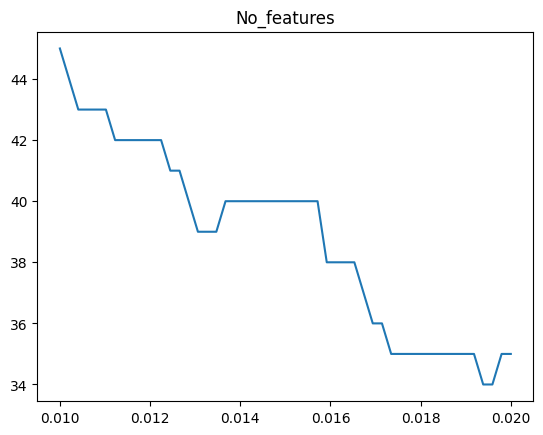

In [23]:
#====================== Đồ thị thay đổi số lượng các feature có trọng số khác 0 với lamda(hay là alpha trong setting) nằm trong khoảng 0.01 tới 0.02

plt.plot(alpha_test, mul_lasso_No_coef)
plt.title("No_features")

In [ ]:
print(train_RSS_LASSO)
print(test_RSS_LASSO)

[1513.492467940952, 1513.5598971553152, 1513.6065686082895, 1513.6651597894606, 1513.730916707295, 1513.8030689443272, 1513.8861870536243, 1513.9487856424346, 1513.9893558087576, 1514.0185514982484]
[4087.2940548747238, 4095.2354694297815, 4103.895926639302, 4117.852712774785, 4133.707918314714, 4148.963869648445, 4156.779794202329, 4164.465858207739, 4170.409623286205, 4173.9403574443295]


### Xây dựng mô hình chặt chẽ hơn với các đặc trưng đã chọn
Khi thực hiện lựa chọn đặc trưng, chúng ta có thể sẽ phải thêm lại độ chệch vào list các đặc trưng. Hãy sử dụng các đặc trưng đã chọn để xây dựng mô hình và tính toán chất lượng dựa trên các chỉ số.

In [ ]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')


In [ ]:
train_features = train_data[ lasso_selected_features ]
train_labels = train_data[ label ]
test_features = test_data[ lasso_selected_features ]
test_labels = test_data[ label ]

In [ ]:
# Viết code ở đây:
model_ridge = RidgeCV(alphas=alpha,cv=10)
model_ridge.fit(train_features, train_labels)

RidgeCV(alphas=array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
        cv=10)

In [ ]:
RSS_train_4 = mean_squared_error(train_labels, model_ridge.predict(train_features))
RSS_test_4 = mean_squared_error(test_labels, model_ridge.predict(test_features))
print("MSE on train and test: {} {}".format(RSS_train_4,RSS_test_4))

MSE on train and test: 1519.952682272491 4014.9657481545983


In [ ]:
print(model_ridge.alpha_)

2069138.0811147902


## Kết hợp mọi thứ trên một mô hình
LASSO đã thực hiện rất tốt, thu nhỏ các đặc trưng nhiễu và không cần thiết, tăng tốc độ tính toán. Bây giờ hãy kết hợp cả 2 kỹ thuật trước đó vào cùng một mô hình.

In [ ]:
# Viết code ở đây:
scaler = StandardScaler()
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[features]
train_labels = train_data[label]
test_features = test_data[features]
test_labels = test_data[label]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#===================== Lựa chọn đặc trưng LASSO

multi_model = LassoCV(alphas = alpha,cv=10)
multi_model.fit(train_features,train_labels)
test_predictions = multi_model.predict(test_features)

ee = multi_model.coef_
mask = ee != 0
lasso_selected_features = []
print("Cac feature co weight != 0:")
for index, i in enumerate(ee):
    if i: lasso_selected_features.append(features[index])
print(lasso_selected_features)

if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')

#======================== Tạo lại các feature cần train

train_features = train_data[ lasso_selected_features ]
train_labels = train_data[ label ]
test_features = test_data[ lasso_selected_features ]
test_labels = test_data[ label ]

#============================Hồi quy RidgeCV

model_ridge = RidgeCV(alphas=alpha,cv=10)
model_ridge.fit(train_features, train_labels)

RSS_train_4 = mean_squared_error(train_labels, model_ridge.predict(train_features))
RSS_test_4 = mean_squared_error(test_labels, model_ridge.predict(test_features))
print("MSE on train and test: {} {}".format(RSS_train_4,RSS_test_4))

Cac feature co weight != 0:
['F_5', 'F_8', 'F_9', 'F_14', 'CC2', 'CC5', 'Base time', 'Post count']
MSE on train and test: 1519.952682272491 4014.9657481545983


In [ ]:
print(model_ridge.coef_, model_ridge.intercept_)

[ 0.01463406  0.04267525  0.14855053  0.12407156  0.07960907  0.04197565
 -0.42859392  0.01048577  0.        ] 14.081102565518323


### Phân phối sai số bình phương
Chúng ta hãy đưa ra kết luận; lưu ý thêm, hãy quan sát cách các sai số bình phương được phân phối.

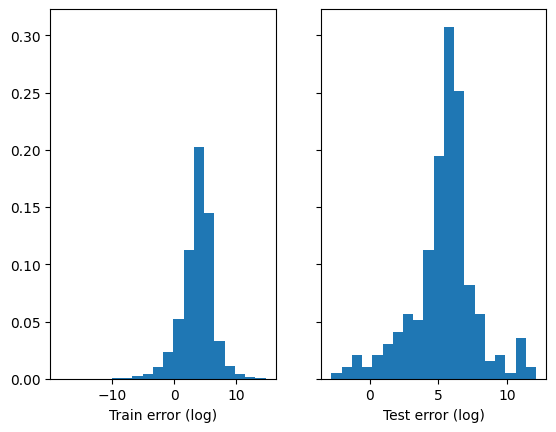

In [ ]:
train_square_errors = np.log( (train_labels - model_ridge.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - model_ridge.predict(test_features)) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()